In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np

seed = 14
torch.manual_seed(seed)
np.random.seed(seed)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


from keras.datasets import imdb
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)


Using cpu device


In [31]:
print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")
print(f"Przykładowa recenzja (długość): {len(X_train[0])}")
print(f"Przykładowa etykieta: {y_train[0]}")

# Statystyki długości sekwencji
lengths = [len(x) for x in X_train]
print(f"\nStatystyki długości sekwencji:")
print(f"  Min: {min(lengths)}, Max: {max(lengths)}, Średnia: {np.mean(lengths):.1f}")


Rozmiar zbioru treningowego: 25000
Rozmiar zbioru testowego: 25000
Przykładowa recenzja (długość): 218
Przykładowa etykieta: 1

Statystyki długości sekwencji:
  Min: 11, Max: 2494, Średnia: 238.7


In [32]:
# Funkcja do padowania sekwencji do równej długości
def pad_sequences(sequences, max_len=None, padding_value=0):
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    
    padded = []
    for seq in sequences:
        if len(seq) > max_len:
            # Przycinamy sekwencję (bierzemy ostatnie max_len elementów)
            padded.append(seq[-max_len:])
        else:
            # Padujemy zerami na początku
            padded.append([padding_value] * (max_len - len(seq)) + list(seq))
    
    return np.array(padded)

# Przygotowanie danych z różnymi długościami sekwencji
def prepare_data(X_train, y_train, X_test, y_test, max_len=None, subset_size=None):
    # Opcjonalne ograniczenie rozmiaru zbioru treningowego
    if subset_size is not None:
        indices = np.random.choice(len(X_train), min(subset_size, len(X_train)), replace=False)
        X_train_subset = [X_train[i] for i in indices]
        y_train_subset = [y_train[i] for i in indices]
    else:
        X_train_subset = X_train
        y_train_subset = y_train
    
    # Padowanie sekwencji
    X_train_padded = pad_sequences(X_train_subset, max_len=max_len)
    X_test_padded = pad_sequences(X_test, max_len=max_len)
    
    # Konwersja do tensorów
    X_train_tensor = torch.LongTensor(X_train_padded)
    y_train_tensor = torch.FloatTensor(y_train_subset)
    X_test_tensor = torch.LongTensor(X_test_padded)
    y_test_tensor = torch.FloatTensor(y_test)
    
    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor

# Test funkcji
X_tr, y_tr, X_te, y_te = prepare_data(X_train, y_train, X_test, y_test, max_len=100, subset_size=5000)
print(f"Kształt X_train po padowaniu: {X_tr.shape}")
print(f"Kształt y_train: {y_tr.shape}")
print(f"Kształt X_test po padowaniu: {X_te.shape}")

Kształt X_train po padowaniu: torch.Size([5000, 100])
Kształt y_train: torch.Size([5000])
Kształt X_test po padowaniu: torch.Size([25000, 100])


In [33]:
class RecurrentNetwork(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=64, rnn_type='RNN'):
        super(RecurrentNetwork, self).__init__()
        
        # Warstwa Embedding - konwertuje indeksy słów na wektory
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        
        # Warstwa rekurencyjna
        if rnn_type == 'RNN':
            self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        elif rnn_type == 'LSTM':
            self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        else:
            raise ValueError(f"Nieznany typ RNN: {rnn_type}")
        
        self.rnn_type = rnn_type
        
        # Warstwa wyjściowa - klasyfikacja binarna
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        # x shape: [batch, seq_len]
        
        # Embedding: [batch, seq_len] -> [batch, seq_len, embed_dim]
        embedded = self.embedding(x)
        
        # RNN: [batch, seq_len, embed_dim] -> [batch, seq_len, hidden_dim]
        if self.rnn_type == 'LSTM':
            output, (hidden, cell) = self.rnn(embedded)
        else:
            output, hidden = self.rnn(embedded)
        
        # Bierzemy ostatni stan ukryty
        # hidden shape: [1, batch, hidden_dim] -> [batch, hidden_dim]
        last_hidden = hidden.squeeze(0)
        
        # Klasyfikacja
        out = self.fc(last_hidden)
        out = self.sigmoid(out)
        
        return out.squeeze(1)

# Test modelu
model_test = RecurrentNetwork(vocab_size=10000, embed_dim=32, hidden_dim=32, rnn_type='RNN')
print(model_test)
print(f"\nLiczba parametrów: {sum(p.numel() for p in model_test.parameters())}")

RecurrentNetwork(
  (embedding): Embedding(10000, 32, padding_idx=0)
  (rnn): RNN(32, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Liczba parametrów: 322145


In [34]:
def train_model(model, train_loader, criterion, optimizer, epochs=10):
    """Funkcja do trenowania modelu."""
    model.train()
    loss_history = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            
            # Forward pass
            pred = model(X)
            loss = criterion(pred, y)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")
    
    return loss_history

def evaluate_model(model, test_loader):
    """Funkcja do ewaluacji modelu."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            predicted = (pred > 0.5).float()
            total += y.size(0)
            correct += (predicted == y).sum().item()
    
    accuracy = correct / total
    return accuracy

def run_experiment(X_train, y_train, X_test, y_test, 
                   vocab_size, embed_dim=64, hidden_dim=64, 
                   rnn_type='RNN', max_len=None, subset_size=5000,
                   batch_size=64, epochs=10, lr=0.001):
    # Przygotowanie danych
    X_tr, y_tr, X_te, y_te = prepare_data(
        X_train, y_train, X_test, y_test, 
        max_len=max_len, subset_size=subset_size
    )
    
    # DataLoadery
    train_dataset = TensorDataset(X_tr, y_tr)
    test_dataset = TensorDataset(X_te, y_te)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Model
    model = RecurrentNetwork(
        vocab_size=vocab_size,
        embed_dim=embed_dim,
        hidden_dim=hidden_dim,
        rnn_type=rnn_type
    ).to(device)
    
    # Kryterium i optymalizator
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Trening
    loss_hist = train_model(model, train_loader, criterion, optimizer, epochs=epochs)
    
    # Ewaluacja
    train_acc = evaluate_model(model, train_loader)
    test_acc = evaluate_model(model, test_loader)
    
    return {'loss': loss_hist, 'train_acc': train_acc, 'test_acc': test_acc, 'model': model}

--- Eksperyment 1: RNN vs LSTM ---

Training RNN...
Epoch 1/10, Loss: 0.6899
Epoch 1/10, Loss: 0.6899
Epoch 2/10, Loss: 0.6606
Epoch 2/10, Loss: 0.6606
Epoch 3/10, Loss: 0.6224
Epoch 3/10, Loss: 0.6224
Epoch 4/10, Loss: 0.5777
Epoch 4/10, Loss: 0.5777
Epoch 5/10, Loss: 0.5391
Epoch 5/10, Loss: 0.5391
Epoch 6/10, Loss: 0.4640
Epoch 6/10, Loss: 0.4640
Epoch 7/10, Loss: 0.4257
Epoch 7/10, Loss: 0.4257
Epoch 8/10, Loss: 0.3826
Epoch 8/10, Loss: 0.3826
Epoch 9/10, Loss: 0.3150
Epoch 9/10, Loss: 0.3150
Epoch 10/10, Loss: 0.2824
Epoch 10/10, Loss: 0.2824
RNN Train Acc: 0.9234, Test Acc: 0.7026

Training LSTM...
RNN Train Acc: 0.9234, Test Acc: 0.7026

Training LSTM...
Epoch 1/10, Loss: 0.6869
Epoch 1/10, Loss: 0.6869
Epoch 2/10, Loss: 0.6300
Epoch 2/10, Loss: 0.6300
Epoch 3/10, Loss: 0.5388
Epoch 3/10, Loss: 0.5388
Epoch 4/10, Loss: 0.4530
Epoch 4/10, Loss: 0.4530
Epoch 5/10, Loss: 0.3769
Epoch 5/10, Loss: 0.3769
Epoch 6/10, Loss: 0.3289
Epoch 6/10, Loss: 0.3289
Epoch 7/10, Loss: 0.2661
Epoch

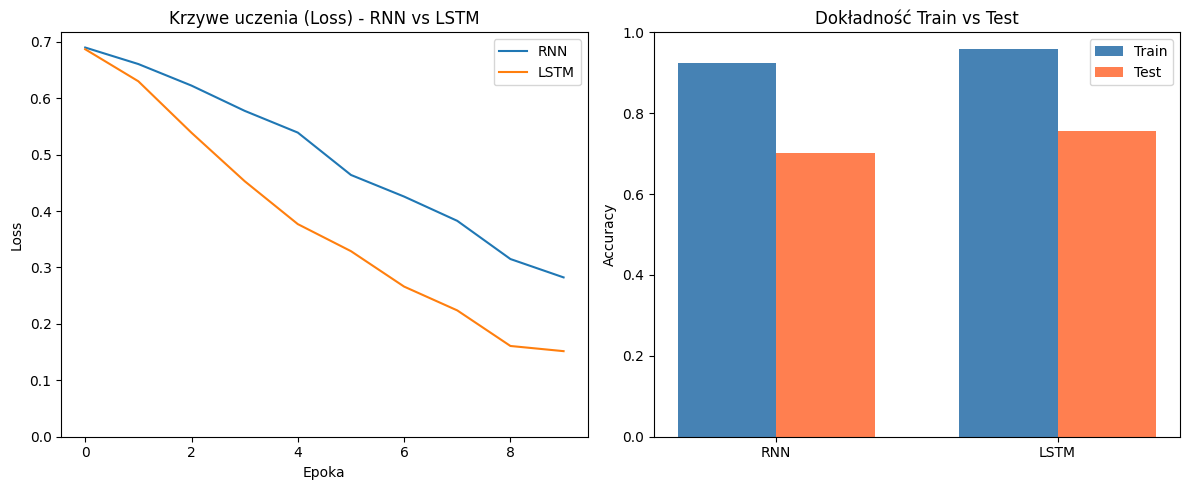

In [35]:
# Eksperyment 1: Porównanie RNN vs LSTM
# Badamy wpływ typu warstwy rekurencyjnej na wyniki klasyfikacji

rnn_types = ['RNN', 'LSTM']
results_exp1 = {}

print("--- Eksperyment 1: RNN vs LSTM ---\n")

for rnn_type in rnn_types:
    print(f"Training {rnn_type}...")
    result = run_experiment(
        X_train, y_train, X_test, y_test,
        vocab_size=10000,
        embed_dim=64,
        hidden_dim=64,
        rnn_type=rnn_type,
        max_len=100,
        subset_size=5000,
        epochs=10
    )
    results_exp1[rnn_type] = result
    print(f"{rnn_type} Train Acc: {result['train_acc']:.4f}, Test Acc: {result['test_acc']:.4f}\n")

# Wizualizacja
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, res in results_exp1.items():
    plt.plot(res['loss'], label=name)
plt.title("Krzywe uczenia (Loss) - RNN vs LSTM")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp1.keys())
x = np.arange(len(names))
width = 0.35
train_accs = [results_exp1[n]['train_acc'] for n in names]
test_accs = [results_exp1[n]['test_acc'] for n in names]
plt.bar(x - width/2, train_accs, width, label='Train', color='steelblue')
plt.bar(x + width/2, test_accs, width, label='Test', color='coral')
plt.xticks(x, names)
plt.title("Dokładność Train vs Test")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 1: RNN vs LSTM

*   **RNN (Vanilla RNN)** ma problem z uczeniem długoterminowych zależności ze względu na zjawisko zanikającego gradientu (vanishing gradient). Dla długich sekwencji tekstowych informacje z początku recenzji mogą być "zapomniane".
*   **LSTM (Long Short-Term Memory)** rozwiązuje ten problem poprzez mechanizm bramek (gates), które kontrolują przepływ informacji. Bramka zapominania, bramka wejściowa i bramka wyjściowa pozwalają sieci selektywnie pamiętać lub zapominać informacje.
*   LSTM zazwyczaj osiąga lepszą dokładność dla zadań klasyfikacji tekstu, szczególnie gdy kontekst z dalszych części sekwencji jest istotny dla klasyfikacji.
*   Wadą LSTM jest większa liczba parametrów i dłuższy czas treningu w porównaniu do prostego RNN.

--- Eksperyment 2: Wymiar warstwy rekurencyjnej ---

Training LSTM with hidden_dim=16...
Epoch 1/10, Loss: 0.6914
Epoch 1/10, Loss: 0.6914
Epoch 2/10, Loss: 0.6799
Epoch 2/10, Loss: 0.6799
Epoch 3/10, Loss: 0.6547
Epoch 3/10, Loss: 0.6547
Epoch 4/10, Loss: 0.5867
Epoch 4/10, Loss: 0.5867
Epoch 5/10, Loss: 0.4987
Epoch 5/10, Loss: 0.4987
Epoch 6/10, Loss: 0.4163
Epoch 6/10, Loss: 0.4163
Epoch 7/10, Loss: 0.3428
Epoch 7/10, Loss: 0.3428
Epoch 8/10, Loss: 0.2800
Epoch 8/10, Loss: 0.2800
Epoch 9/10, Loss: 0.2269
Epoch 9/10, Loss: 0.2269
Epoch 10/10, Loss: 0.1824
Epoch 10/10, Loss: 0.1824
Hidden dim 16 Train Acc: 0.9562, Test Acc: 0.7431

Training LSTM with hidden_dim=32...
Hidden dim 16 Train Acc: 0.9562, Test Acc: 0.7431

Training LSTM with hidden_dim=32...
Epoch 1/10, Loss: 0.6895
Epoch 1/10, Loss: 0.6895
Epoch 2/10, Loss: 0.6620
Epoch 2/10, Loss: 0.6620
Epoch 3/10, Loss: 0.5836
Epoch 3/10, Loss: 0.5836
Epoch 4/10, Loss: 0.4865
Epoch 4/10, Loss: 0.4865
Epoch 5/10, Loss: 0.4096
Epoch 5/10

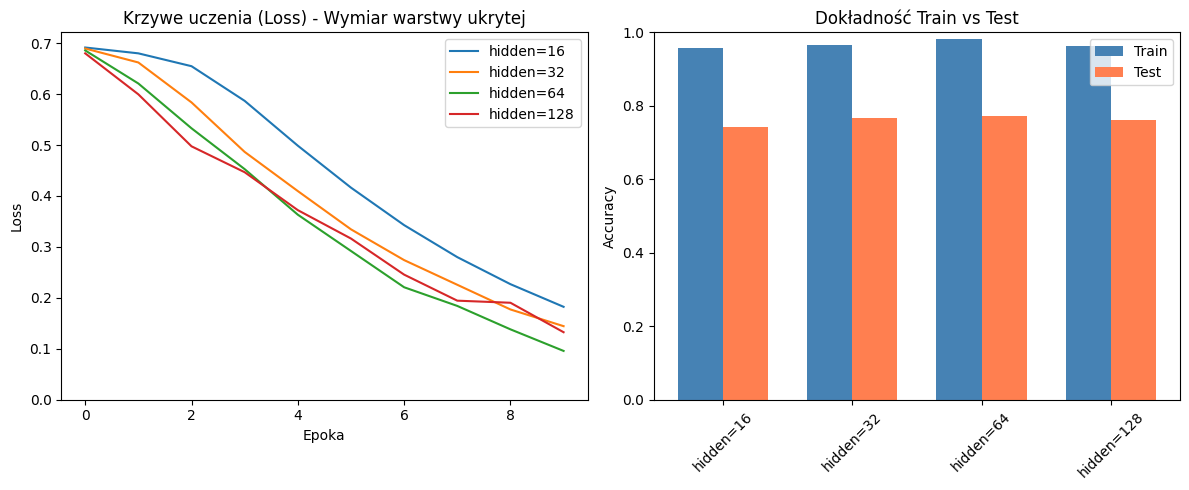

In [36]:
# Eksperyment 2: Wymiar warstwy rekurencyjnej
# Badamy wpływ rozmiaru warstwy ukrytej na wyniki

hidden_dims = [16, 32, 64, 128]
results_exp2 = {}

print("--- Eksperyment 2: Wymiar warstwy rekurencyjnej ---\n")

for h_dim in hidden_dims:
    print(f"Training LSTM with hidden_dim={h_dim}...")
    result = run_experiment(
        X_train, y_train, X_test, y_test,
        vocab_size=10000,
        embed_dim=64,
        hidden_dim=h_dim,
        rnn_type='LSTM',
        max_len=100,
        subset_size=5000,
        epochs=10
    )
    results_exp2[f'hidden={h_dim}'] = result
    print(f"Hidden dim {h_dim} Train Acc: {result['train_acc']:.4f}, Test Acc: {result['test_acc']:.4f}\n")

# Wizualizacja
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
for name, res in results_exp2.items():
    plt.plot(res['loss'], label=name)
plt.title("Krzywe uczenia (Loss) - Wymiar warstwy ukrytej")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp2.keys())
x = np.arange(len(names))
width = 0.35
train_accs = [results_exp2[n]['train_acc'] for n in names]
test_accs = [results_exp2[n]['test_acc'] for n in names]
plt.bar(x - width/2, train_accs, width, label='Train', color='steelblue')
plt.bar(x + width/2, test_accs, width, label='Test', color='coral')
plt.xticks(x, names, rotation=45)
plt.title("Dokładność Train vs Test")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 2: Wymiar warstwy rekurencyjnej

*   **Mały wymiar (16, 32)** może być niewystarczający do zakodowania wszystkich istotnych informacji z tekstu. Sieć ma ograniczoną "pojemność" do reprezentowania złożonych wzorców językowych.
*   **Większy wymiar (64, 128)** pozwala na bardziej ekspresywną reprezentację, co zazwyczaj przekłada się na lepszą dokładność klasyfikacji.
*   **Zbyt duży wymiar** może prowadzić do overfittingu (szczególnie przy małej ilości danych treningowych) oraz znacznie wydłuża czas treningu.
*   Optymalny wymiar warstwy ukrytej to kompromis między zdolnością reprezentacji a ryzykiem overfittingu i kosztami obliczeniowymi.

Maksymalna długość sekwencji w danych: 2494

--- Eksperyment 3: Wpływ przycinania sekwencji ---

Training LSTM with max_len=10...
Epoch 1/10, Loss: 0.6863
Epoch 1/10, Loss: 0.6863
Epoch 2/10, Loss: 0.6407
Epoch 2/10, Loss: 0.6407
Epoch 3/10, Loss: 0.5681
Epoch 3/10, Loss: 0.5681
Epoch 4/10, Loss: 0.4949
Epoch 4/10, Loss: 0.4949
Epoch 5/10, Loss: 0.4252
Epoch 5/10, Loss: 0.4252
Epoch 6/10, Loss: 0.3573
Epoch 6/10, Loss: 0.3573
Epoch 7/10, Loss: 0.2809
Epoch 7/10, Loss: 0.2809
Epoch 8/10, Loss: 0.2155
Epoch 8/10, Loss: 0.2155
Epoch 9/10, Loss: 0.1527
Epoch 9/10, Loss: 0.1527
Epoch 10/10, Loss: 0.1153
Epoch 10/10, Loss: 0.1153
max_len=10 Train Acc: 0.9786, Test Acc: 0.6488

Training LSTM with max_len=20...
max_len=10 Train Acc: 0.9786, Test Acc: 0.6488

Training LSTM with max_len=20...
Epoch 1/10, Loss: 0.6869
Epoch 1/10, Loss: 0.6869
Epoch 2/10, Loss: 0.6368
Epoch 2/10, Loss: 0.6368
Epoch 3/10, Loss: 0.5482
Epoch 3/10, Loss: 0.5482
Epoch 4/10, Loss: 0.4689
Epoch 4/10, Loss: 0.4689
Epoch 

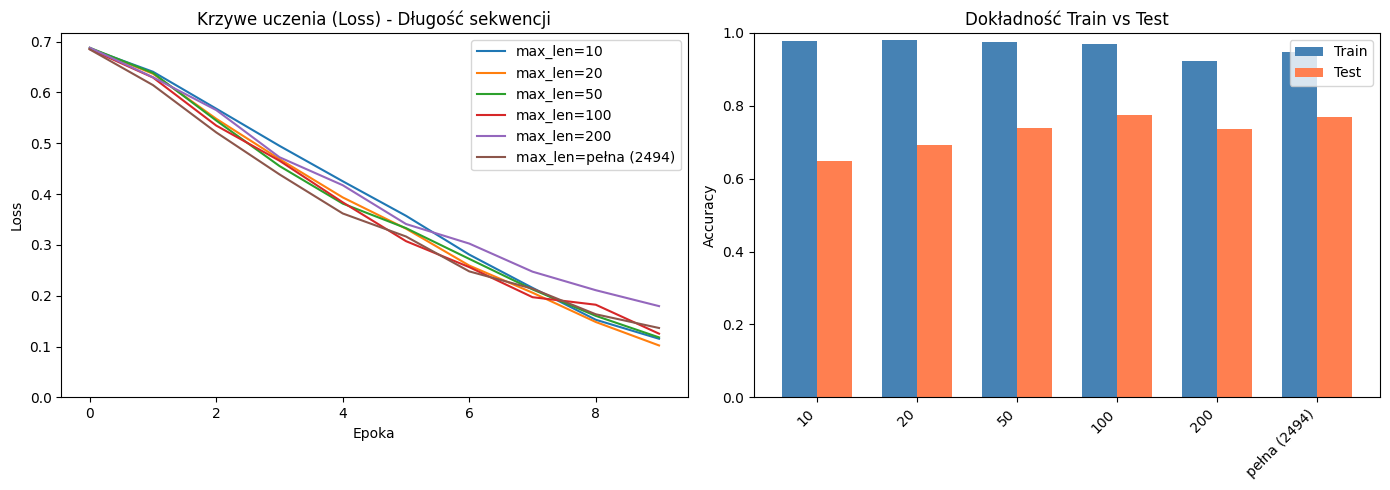

In [37]:
# Eksperyment 3: Wpływ przycinania sekwencji do niepełnej długości
# Porównujemy różne długości sekwencji: 10, 20, 50, 100, pełna długość

# Najpierw wyznaczamy maksymalną długość w zbiorze
max_length_train = max(len(seq) for seq in X_train)
max_length_test = max(len(seq) for seq in X_test)
max_length = max(max_length_train, max_length_test)
print(f"Maksymalna długość sekwencji w danych: {max_length}")

sequence_lengths = [10, 20, 50, 100, 200, None]  # None = pełna długość
results_exp3 = {}

print("\n--- Eksperyment 3: Wpływ przycinania sekwencji ---\n")

for seq_len in sequence_lengths:
    name = f"max_len={seq_len}" if seq_len else f"max_len=pełna ({max_length})"
    print(f"Training LSTM with {name}...")
    
    result = run_experiment(
        X_train, y_train, X_test, y_test,
        vocab_size=10000,
        embed_dim=64,
        hidden_dim=64,
        rnn_type='LSTM',
        max_len=seq_len,
        subset_size=5000,
        epochs=10
    )
    results_exp3[name] = result
    print(f"{name} Train Acc: {result['train_acc']:.4f}, Test Acc: {result['test_acc']:.4f}\n")

# Wizualizacja
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
for name, res in results_exp3.items():
    plt.plot(res['loss'], label=name)
plt.title("Krzywe uczenia (Loss) - Długość sekwencji")
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.ylim(bottom=0)
plt.legend()

plt.subplot(1, 2, 2)
names = list(results_exp3.keys())
x = np.arange(len(names))
width = 0.35
train_accs = [results_exp3[n]['train_acc'] for n in names]
test_accs = [results_exp3[n]['test_acc'] for n in names]
plt.bar(x - width/2, train_accs, width, label='Train', color='steelblue')
plt.bar(x + width/2, test_accs, width, label='Test', color='coral')
plt.xticks(x, [n.replace('max_len=', '') for n in names], rotation=45, ha='right')
plt.title("Dokładność Train vs Test")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()
plt.show()

### Wnioski - Eksperyment 3: Wpływ przycinania sekwencji

*   **Bardzo krótkie sekwencje (10, 20 słów)** tracą większość informacji z recenzji. Dla klasyfikacji sentymentu często najważniejsze słowa kluczowe (np. "świetny", "okropny") mogą występować w różnych miejscach tekstu, więc przycinanie do tak krótkiej długości drastycznie obniża dokładność.
*   **Umiarkowana długość (50-100 słów)** często stanowi dobry kompromis między wydajnością a dokładnością. Wiele recenzji zawiera kluczowe informacje o sentymencie w pierwszych/ostatnich zdaniach.
*   **Pełna długość sekwencji** teoretycznie zachowuje całą informację, ale:
    - Znacznie wydłuża czas treningu (więcej kroków RNN)
    - Może być podatna na problem zanikającego gradientu (dla vanilla RNN)
    - Wymaga więcej pamięci GPU/RAM
    - Padowanie krótszych sekwencji do maksymalnej długości wprowadza dużo "szumu" (zer)

PODSUMOWANIE WYNIKÓW (Train Acc / Test Acc)

--- Eksperyment 1: RNN vs LSTM ---
  RNN: Train=0.9234, Test=0.7026
  LSTM: Train=0.9592, Test=0.7554

--- Eksperyment 2: Wymiar warstwy rekurencyjnej ---
  hidden=16: Train=0.9562, Test=0.7431
  hidden=32: Train=0.9660, Test=0.7656
  hidden=64: Train=0.9822, Test=0.7716
  hidden=128: Train=0.9620, Test=0.7613

--- Eksperyment 3: Długość sekwencji ---
  max_len=10: Train=0.9786, Test=0.6488
  max_len=20: Train=0.9798, Test=0.6925
  max_len=50: Train=0.9744, Test=0.7393
  max_len=100: Train=0.9702, Test=0.7735
  max_len=200: Train=0.9226, Test=0.7353
  max_len=pełna (2494): Train=0.9462, Test=0.7680


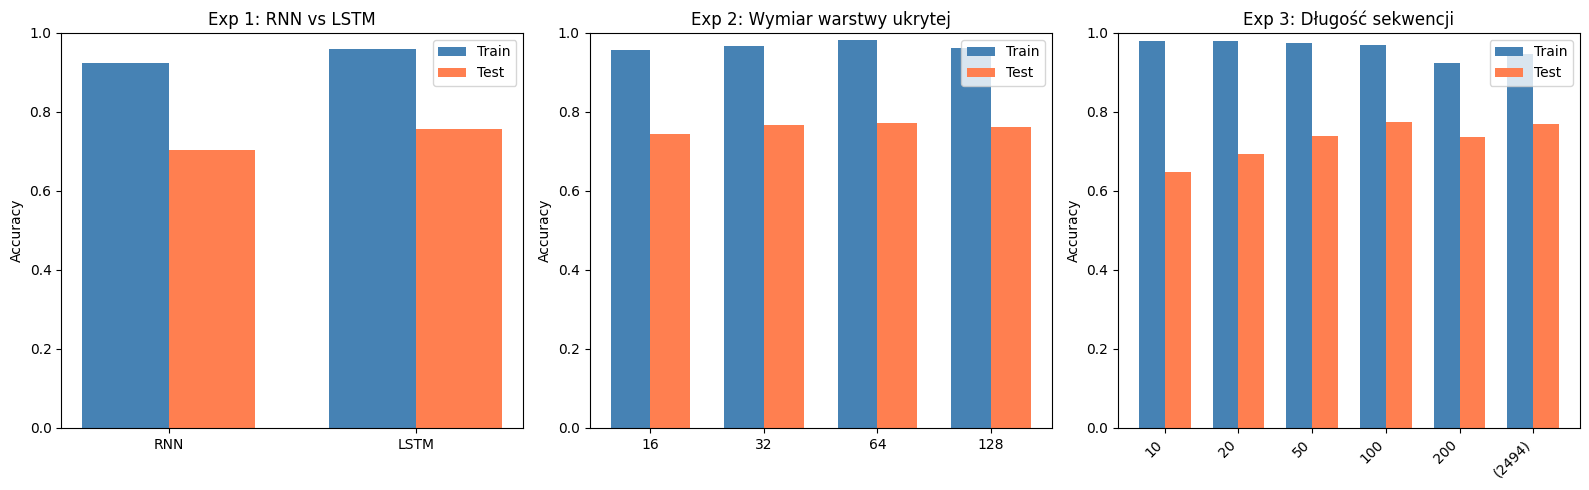

In [38]:
# Podsumowanie wszystkich eksperymentów
print("=" * 60)
print("PODSUMOWANIE WYNIKÓW (Train Acc / Test Acc)")
print("=" * 60)

print("\n--- Eksperyment 1: RNN vs LSTM ---")
for name, res in results_exp1.items():
    print(f"  {name}: Train={res['train_acc']:.4f}, Test={res['test_acc']:.4f}")

print("\n--- Eksperyment 2: Wymiar warstwy rekurencyjnej ---")
for name, res in results_exp2.items():
    print(f"  {name}: Train={res['train_acc']:.4f}, Test={res['test_acc']:.4f}")

print("\n--- Eksperyment 3: Długość sekwencji ---")
for name, res in results_exp3.items():
    print(f"  {name}: Train={res['train_acc']:.4f}, Test={res['test_acc']:.4f}")

# Wizualizacja zbiorcza - Train vs Test dla każdego eksperymentu
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Eksperyment 1
ax1 = axes[0]
names1 = list(results_exp1.keys())
x1 = np.arange(len(names1))
width = 0.35
train_accs1 = [results_exp1[n]['train_acc'] for n in names1]
test_accs1 = [results_exp1[n]['test_acc'] for n in names1]
ax1.bar(x1 - width/2, train_accs1, width, label='Train', color='steelblue')
ax1.bar(x1 + width/2, test_accs1, width, label='Test', color='coral')
ax1.set_xticks(x1)
ax1.set_xticklabels(names1)
ax1.set_title("Exp 1: RNN vs LSTM")
ax1.set_ylabel("Accuracy")
ax1.set_ylim(0, 1)
ax1.legend()

# Eksperyment 2
ax2 = axes[1]
names2 = list(results_exp2.keys())
x2 = np.arange(len(names2))
train_accs2 = [results_exp2[n]['train_acc'] for n in names2]
test_accs2 = [results_exp2[n]['test_acc'] for n in names2]
ax2.bar(x2 - width/2, train_accs2, width, label='Train', color='steelblue')
ax2.bar(x2 + width/2, test_accs2, width, label='Test', color='coral')
ax2.set_xticks(x2)
ax2.set_xticklabels([n.replace('hidden=', '') for n in names2])
ax2.set_title("Exp 2: Wymiar warstwy ukrytej")
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0, 1)
ax2.legend()

# Eksperyment 3
ax3 = axes[2]
names3 = list(results_exp3.keys())
x3 = np.arange(len(names3))
train_accs3 = [results_exp3[n]['train_acc'] for n in names3]
test_accs3 = [results_exp3[n]['test_acc'] for n in names3]
ax3.bar(x3 - width/2, train_accs3, width, label='Train', color='steelblue')
ax3.bar(x3 + width/2, test_accs3, width, label='Test', color='coral')
ax3.set_xticks(x3)
ax3.set_xticklabels([n.replace('max_len=', '').replace('pełna ', '') for n in names3], rotation=45, ha='right')
ax3.set_title("Exp 3: Długość sekwencji")
ax3.set_ylabel("Accuracy")
ax3.set_ylim(0, 1)
ax3.legend()

plt.tight_layout()
plt.show()

### Wnioski końcowe

**Sieci rekurencyjne dla danych sekwencyjnych:**

1. **Typ warstwy rekurencyjnej (RNN vs LSTM)**:
   - LSTM zazwyczaj przewyższa vanilla RNN dla zadań klasyfikacji tekstu
   - LSTM lepiej radzi sobie z długoterminowymi zależnościami dzięki mechanizmowi bramek
   - Koszt: LSTM ma ~4x więcej parametrów niż RNN o tym samym wymiarze

2. **Wymiar warstwy rekurencyjnej**:
   - Większy wymiar = większa zdolność reprezentacji, ale ryzyko overfittingu
   - Dla zbioru IMDB, wymiar 64-128 zazwyczaj daje dobre wyniki
   - Należy dostosować do rozmiaru zbioru danych i złożoności zadania

3. **Długość sekwencji**:
   - Zbyt krótkie sekwencje tracą kluczowe informacje
   - Zbyt długie sekwencje są kosztowne obliczeniowo i mogą wprowadzać szum
   - Optymalny kompromis to zwykle 100-200 słów dla recenzji filmowych

**Praktyczne wskazówki:**
- Warstwa Embedding konwertuje słowa na wektory i może być trenowana end-to-end
- Padowanie jest niezbędne do batchowania sekwencji o różnych długościach
- Dla lepszych wyników można użyć dwukierunkowych LSTM (BiLSTM) lub stackowanych warstw